In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [7]:
# Load gigaword dataset
dev_text = open('data/dev.src.txt', 'r').readlines()
test_text = open('data/test.src.txt', 'r').readlines()
train_text = open('data/train.src.txt', 'r').readlines()
dev_title = open('data/dev.tgt.txt', 'r').readlines()
test_title = open('data/test.tgt.txt', 'r').readlines()
train_title = open('data/train.tgt.txt', 'r').readlines()

# Add all files to single data frame
data = pd.DataFrame({'text': train_text + dev_text + test_text, 'title': train_title + dev_title + test_title})

In [10]:
data.head()

,text,title
0,australia 's current account deficit shrunk by...,australian current account deficit narrows sha...
1,at least two people were killed in a suspected...,at least two dead in southern philippines blast\n
2,australian shares closed down #.# percent mond...,australian stocks close down #.# percent\n
3,south korea 's nuclear envoy kim sook urged no...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy\n


In [25]:
import re

# Clean text from column
def clean_text(column):
    new_text = []
    for row in column:
        row = re.sub('<[^>]*>', '', row)
        row = re.sub('[^a-zA-Z0-9]', ' ', row)
        row = re.sub(' +', ' ', row)
        row = row.strip()
        row = row.lower()
        new_text.append(row)

    return new_text

In [26]:
processed_text = clean_text(data['text'])
processed_title = clean_text(data['title'])

In [30]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in processed_title]

In [31]:
processed_text[1]

'at least two people were killed in a suspected bomb attack on a passenger bus in the strife torn southern philippines on monday the military said'

In [32]:
summary[1]

'_START_ at least two dead in southern philippines blast _END_'

In [33]:
data['clean_text'] = pd.Series(processed_text)
data['clean_title'] = pd.Series(summary)

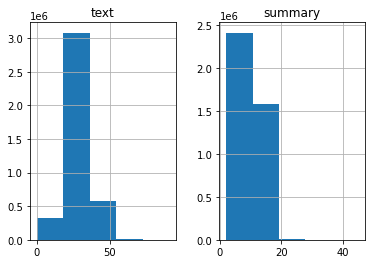

In [35]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in data['clean_text']:
    text_count.append(len(sent.split()))
    
for sent in data['clean_title']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [36]:
max_text_len = max(text_count)
max_summary_len = max(summary_count)

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data['clean_text'], data['clean_title'], test_size = 0.2, random_state = 42)

In [38]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [42]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  7.831374138629915


In [43]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_test)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 90953


In [44]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_test) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 7.390643414692469
Size of vocabulary in Y = 54221


In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 91)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 91, 200)      18190600    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 91, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [51]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/time_distributed/dense/MatMul' defined at (most recent call last):
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\kernelbase.py", line 369, in dispatch_shell
      await result
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\seand\AppData\Local\Temp\ipykernel_19316\2045958862.py", line 1, in <cell line: 1>
      history = model.fit(
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\layers\wrappers.py", line 267, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\seand\anaconda3\envs\thesisenv\lib\site-packages\keras\layers\core\dense.py", line 219, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'model/time_distributed/dense/MatMul'
OOM when allocating tensor with shape[5632,54221] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/time_distributed/dense/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14052]